아래 내용은 Ethan Rosenthal의 블로그의 내용과 소스코드를 바탕으로 번역 및 일부 수정한 내용입니다.

원본을 보시고 싶으신 분은 아래 사이트를 방문해주세요

- 블로그: http://blog.ethanrosenthal.com/
- github: https://github.com/EthanRosenthal/DataPiques_source

앞으로 몇 번에 걸쳐서 collaborative filtering에 속해있는 Matrix Factorization(MF)을 살펴볼 예정입니다. 이 페이지에서는 MF의 목적 함수를 정의하고 이를 학습하는 대표적인 방법 2가지 ALS, SGD의 알고리즘을 살펴보고 구현 할 것입니다.

### Matrix factorization 가정 
- 각 user는 k개의 feature로 이루어진 vector로 표현될 수 있으며 각 feature는 user가 SF 영화를 얼마나 좋아하는 지 등의 특징을 나타낸다. (user의 item에 대한 선호도)
- 각 item은 k개의 feature로 이루어진 vector로 표현될 수 있으며 각 feature는 item이 얼마나 SF 영화에 가까운 장르인지를 나타낸다. 
(item의 특징)
- user vector와 item vector의 각각 매칭되는 feature들을 곱한 뒤 모두 더하면(*내적*) 이는 user가 item에 대한 예상 평점이라고 볼 수 있다.

위 가정에서 좋은 점은 우리가 k개의 feature 개수만 정해주고 아무런 개입없이 학습만 시켜주면 해당되는 값을 얻을 수 있다는 점이다. <br>
그럼 이제, 학습을 위한 목적 함수를 만들어보자.

### 목적 함수 

먼저 함수에 사용할 항들의 notation을 짚고 넘어가자. $k$는 feature의 개수, $\textbf{x}_{u}$는 u번째 user의 vector, $\textbf{y}_{i}$는 i번째 item의 vector이다. 위에서 가정했듯, $\textbf{x}_{u}$, $\textbf{y}_{i}$을 내적하면 예상 평점을 구할 수 있다. 아래와 같이 $\hat r_{ui}$를 우리가 얻은 vector로부터 구한 예상 평점이라고 하자.

$$\hat r_{ui} = \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} = \sum\limits_{k} x_{uk}y_{ki}$$

자, 그럼 학습 시킬 때의 진짜 평점도 있을 것이다. 이는 $r_{ui}$로 두자. 이제 목적 함수를 만들기 위한 준비가 끝났다.

Matrix factorization을 통해 궁극적으로 원하는 내용은 ***우리가 나타낸 k개의 feature(혹은 latent factor)로 이루어진 user, item으로부터 예상 평점을 구했을 때 진짜 평점과 완전히 같은 것.*** 이다. 이를 식으로 나타내면 아래와 같으며 $L$을 최소화 시켰을 때 우리가 원하는 $\textbf{x}_{u}$, $\textbf{y}_{i}$을 구할 수 있다. 뒤 항들은 생소할 수 있는데 overfitting을 막기 위해 $L_{2}$ regularization term을 적용한 것이다.

$$L = \sum\limits_{u,i \in S}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i})^{2} + \lambda_{x} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{y} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

목적 함수를 정의했으니 이를 어떻게 학습할 건지에 대한 방법을 정해야 한다. 위에서 소개했듯 ALS, SGD를 차례로 보도록 하겠다.

### Alternaing Least Squares (ALS)

ALS 방법은 지금 우리가 학습시켜야 할 항이 2개 ($\textbf{x}_{u}, \textbf{y}_{i}$)가 있는데 $\textbf{x}_{u}$를 학습할 때는 $\textbf{y}_{i}$를 상수로 두고, 반대로 $\textbf{y}_{i}$를 학습할 때는 $\textbf{x}_{u}$를 상수로 두고 학습한다.

수식을 통해 보면 좀 더 이해가 잘 된다. 우리가 원하는 건 $L$이 최소값일 때의 $\textbf{x}_{u}$를 구하는 것이므로 $\dfrac{\partial L}{\partial \textbf{x}_{u}} = 0$ 을 만족하는 $\textbf{x}_{u}$ 값을 구해주면 된다. 이게 성립하는 이유는 $\textbf{y}_{i}$ 항을 
상수로 뒀기 때문에 $\textbf{x}_{u}$에 대한 식만 풀면 되고 *convex* 해서 그냥 등식을 풀어주면 되기 때문이다. 

그래서 최종적으로 $\textbf{x}_{u}^{\intercal} = \textbf{r}_{u}Y(Y^{\intercal}Y + \lambda_{x}I)^{-1}$ 값으로 update를 해주면 된다.

$$\frac{\partial L}{\partial \textbf{x}_{u}} = - 2 \sum\limits_{i}(r_{ui} - \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}) \textbf{y}_{i}^{\intercal} + 2 \lambda_{x} \textbf{x}_{u}^{\intercal}$$

$$0 = -(\textbf{r}_{u} - \textbf{x}_{u}^{\intercal} Y^{\intercal})Y + \lambda_{x} \textbf{x}_{u}^{\intercal}$$

$$\textbf{x}_{u}^{\intercal}(Y^{\intercal}Y + \lambda_{x}I) = \textbf{r}_{u}Y$$

$$\textbf{x}_{u}^{\intercal} = \textbf{r}_{u}Y(Y^{\intercal}Y + \lambda_{x}I)^{-1}$$

$\textbf{y}_{i}$에 대해서도 마찬가지이다. 위와 같이 수식을 풀어서 쓰면 아래 등식을 푸는 과정이 되고 최종적으로 
$ \textbf{y}_{i}^{\intercal} =  \textbf{r}_{i} X  ( X^{\intercal}X +  \lambda_{y}I) ^{-1}$ 값을 update 해주면 된다.


$$\frac{\partial L}{\partial \textbf{y}_{i}} = - 2 \sum\limits_{i}(r_{iu} - \textbf{y}_{i}^{\intercal} \cdot{} \textbf{x}_{u}) \textbf{x}_{u}^{\intercal} + 2 \lambda_{y} \textbf{y}_{i}^{\intercal}$$

$$0 = -(\textbf{r}_{i} - \textbf{y}_{i}^{\intercal} X^{\intercal})X + \lambda_{y} \textbf{y}_{i}^{\intercal}$$

$$ \textbf{y}_{i}^{\intercal} ( X^{\intercal}X +  \lambda_{y}I) =  \textbf{r}_{i} X$$

$$ \textbf{y}_{i}^{\intercal} =  \textbf{r}_{i} X  ( X^{\intercal}X +  \lambda_{y}I) ^{-1}$$

#### ALS 내용을 정리해보자. <br>
1. user, item을 학습시켜야 하는데 한 쪽을 학습시킬 때는 다른 한 쪽은 상수로 취급한다.
2. 한 쪽이 상수로 취급되면 목적함수가 최소일 때의 user(혹은 item) vector 값을 등식 계산을 통해 얻을 수 있다.
3. 2번 과정을 계속 반복하면 최적의 user, item vector를 구할 수 있다. 

### 코드 구현

아래 코드에서는 위에서 언급한 목적 함수를 구현하고, ALS 방법을 통해서 user, item의 vector를 학습시킨다.

In [7]:
import numpy as np
import pandas as pd

# seed를 지정한다. 
np.random.seed(0)

In [8]:
# 데이터가 있는 파일로 폴더를 지정한다. 
cd ../dataset/ml-100k/

SyntaxError: invalid syntax (<ipython-input-8-074ad1f07ada>, line 2)

In [29]:
# 데이터 불러오기
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)

# user_item 형식으로 평점 데이터를 만든다. (user: 행, item: 열)
ratings = df.groupby(['user_id', 'item_id'])['rating'].mean().unstack().fillna(0).values

# user가 가장 적게 rating한 수를 확인하자. -> 20인데, 우리는 test 데이터를 만들 때 user 별로 10개씩 뽑아서 만들 생각이다. 
min_rating_count = min([len(ratings[i].nonzero()[0]) for i in range(ratings.shape[0])])

# training, test 데이터로 나눈다.
# test는 0으로 이루어진 행열을 만들어주고 전체 데이터에서 0이 아닌 값을 user 별로 10개씩 뽑아서 넣어준다.
# train은 반대로 뽑힌 값을 0으로 만들어준다. 
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        # user 별로 zero가 아닌 값을 10개 뽑고 train은 0의 값을, test에는 실제 값을 입력해준다. 
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # train, test set은 곱할 경우 모두 0의 값을 갖게 된다. 
    assert(np.all((train * test) == 0)) 
    return train, test

train, test = train_test_split(ratings)

### 데이터셋
- train: 전체 데이터에서 user 별로 10개씩 평점을 제외한 데이터 
- test: user 별로 10개씩 평점을 가진 데이터 

### 평가방법
- mse: 
    - train: train의 non-zero 데이터와 그에 맞는 예측된 데이터를 비교한다. (train 데이터는 모두 본 적이 있는 데이터이다.)
    - test: test의 non-zero 데이터와 그에 맞는 예측된 데이터를 비교한다. (train할 때 본 적이 없는 데이터이므로 test이다.)

In [33]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # 올바른 평가를 위해서 actual(전부) 데이터에서 zero가 아닌 값과 pred(예측) 값을 비교한다. 
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [34]:
# np.linalg.solve는 linear matrix equation의 해를 구하는 함수이다. 
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        matrix factorization 모델을 학습해서 sparse한 데이터에 대한 
        예측이 목적이다. ratings는 user x item 형식의 행렬로 가정한다. 
        
        Params
        ======
        ratings : (ndarray)
            User x Item 행렬이며 평점 값을 갖는다. 
        
        n_factors : (int)
            factor의 수로 사용할 k의 값. item, user의 vector 차원을 나타낸다. 
        
        item_reg : (float)
            item factor에 대한 regularization term
        
        user_reg : (float)
            user factor에 대한 regularization term
        
        verbose : (bool)
            학습 결과 출력 여부 
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        user 혹은 item에 대해 각각 번갈아서 update하는 step이다. 
        type에 지정해주면 다른 항을 상수로 지정한 뒤 update 값을 구해서 반환해준다. 
        """
        if type == 'user':            
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ scratch부터 모델을 학습시킨다."""
        # 초기 user vector, item vector 값을 지정해준다. 
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        학습된 모델을 계속해서 학습하고 싶을 때 사용한다. n_iter만큼 추가 학습한다.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ 
        전체 user, item에 대한 예측 평점을 반환한다. 연산량이 크다.
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def predict(self, u, i):
        """ 1개 user, 1개 item에 대한 예측 평점을 반환한다. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        
    def calculate_learning_curve(self, iter_array, test):
        """
        training시 iteration에 따른 MSE를 반환해준다. 
        
        Params
        ======
        iter_array : (list)
            learning curve에서 중간 상황을 보여줄 iteration 값 지정 e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            테스트 데이터셋 (assumed to be user x item).
        
        새로 생기는 class attributes:
        
        train_mse : (list)
            iter_array에 따른 Train 데이터 MSE 값
        test_mse : (list)
            iter_array에 따른 Test 데이터 MSE 값
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        # iteration에 따른 에러율 확인
        for (i, n_iter) in enumerate(iter_array):
            # verbose == True이면 학습 내용 출력
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            # 처음부터 학습
            if i == 0:
                self.train(n_iter - iter_diff)
            # 계속해서 학습
            else:
                self.partial_train(n_iter - iter_diff)
            # 전체에 대한 prediction 값 구하기 
            predictions = self.predict_all()
            
            # mse 값을 확인하자. 
            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter

40 latent factor로 regularization 없이 시도해보고 learning curve를 그려보자.

In [35]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

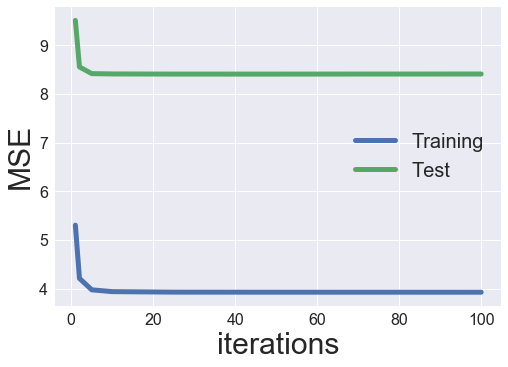

In [37]:
plot_learning_curve(iter_array, MF_ALS)

### 평가 및 개선 작업

overfitting이 일어나서 training error는 낮고 test error는 높은 것으로 보인다. 이제 hyperparameter들을 모아서 적절한 값을 찾아보자. 사용할 방법은 Grid-search를 사용할 것이며 코드가 최적화가 되어 있지 않아서 느리므로 적당한 수의 hyperparameter로 테스트 해 보길 바란다.

In [41]:
# Grid-search 수행할 hyperparamter 값
latent_factors = [5, 10, 20] # 40, 80]
regularizations = [0.01, 0.1] # 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5] # 10, 25, 50, 100]

# parameter 초기 저장 값(의미 없음) 지정. 
best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

# 위 parameter들에 대해서 학습하고 성능이 가장 좋은 hyperparameter를 기억한다. 
for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 5
Regularization: 0.01
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fd9f1c3b7a0>
n_factors                                                   5
n_iter                                                      5
reg                                                      0.01
test_mse                                              8.74779
train_mse                                              6.1493
dtype: object
Regularization: 0.1
Factors: 10
Regularization: 0.01
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fd9f4a3fd88>
n_factors                                                  10
n_iter                                                      5
reg                                                      0.01
test_mse                                               8.1177
train_mse                                             5.41917
dtype: object
Regularization: 0.1
Factors: 20
Regularization: 0.01
New optimal hyperparameters
model 

In [43]:
best_params

{'model': <__main__.ExplicitMF instance at 0x7fd9f1ae6bd8>,
 'n_factors': 20,
 'n_iter': 5,
 'reg': 0.01,
 'test_mse': 8.0520565418181587,
 'train_mse': 4.8139088724887973}

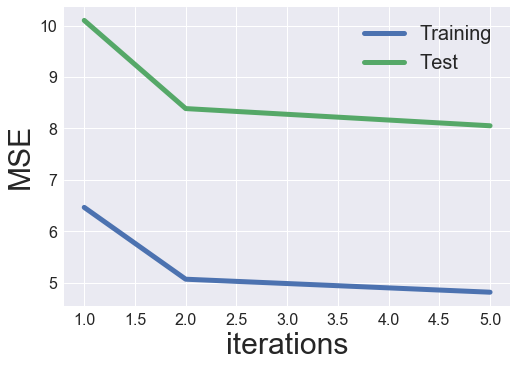

In [42]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

best parameter는 factor가 20, reg이 0.01일 때로 hyperparameter 조절을 통해 위에서 본 결과보다 test error를 어느 정도 개선하고 overfitting 문제를 일부 해결했다. 아래에서 SGD까지 보고 item 간 similarity를 살펴보도록 하자. 

### Stochastic Gradient Descent (SGD)

SGD에서도 위 ALS에서 사용한 목적 함수를 그대로 사용하며 학습 방법만 약간의 차이가 있다. ALS에서는 user를 update할 때는 item을 상수로 두고 등식을 풀었는데 SGD에서는 두 항에 대해서 각각 gradient를 구한 뒤 현재 값에 일부 update를 시켜서 수렴할 때까지 update를 하는 방식을 취한다.

SGD를 다룰 떄 추가적인 항들을 넣어줄 것인데 바로 ***bias***이다. user 중에는 남들보다 조금 더 비판적인 사람이 있을 수 있고 관대한 사람들도 있을 수 있다. item도 지금 상황에 특정 장르가 인기가 많을 수도 있고 적을 수도 있다. 이런 특징들을 반영해주는 것이 bias이다. 

bias를 추가해서 예상 평점을 식으로 나타내면 아래와 같다. 여기서 $\mu$는 overall average rating으로 전체적인 rating의 평균을 나타내서 평점이 이를 기준으로 bias를 고려해서 위 아래로 나타나도록 하는 역할을 한다. $$ \hat r_{ui} = \mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i} $$ 

목적 함수를 다시 정의하면 아래 식이 된다. 
$$L = \sum\limits_{u,i}(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))^{2} + 
\lambda_{xb} \sum\limits_{u} \left\Vert b_{u} \right\Vert^{2} + \lambda_{yb} \sum\limits_{i} \left\Vert b_{i} \right\Vert^{2} + \lambda_{xf} \sum\limits_{u} \left\Vert \textbf{x}_{u} \right\Vert^{2} + \lambda_{yf} \sum\limits_{u} \left\Vert \textbf{y}_{i} \right\Vert^{2}$$

각 항 별로, gradient를 구해서 $\eta$(learning rate) 만큼 update를 시켜줘야 한다. 예시로 $b_u$에 대해서만 구해보도록 하자.
아래 식에서 $e_{ui}$는 예측에 대한 error를 나타낸다. 

$$ b_{u} \leftarrow b_{u} - \eta \frac{\partial L}{\partial b_{u}} $$

$$ \frac{\partial L}{\partial b_{u}} = 2(r_{ui} - (\mu + b_{u} + b_{i} + \textbf{x}_{u}^{\intercal} \cdot{} \textbf{y}_{i}))(-1) + 2\lambda_{xb} b_{u} $$
$$ \frac{\partial L}{\partial b_{u}} = 2(e_{ui})(-1) + 2\lambda_{xb} b_{u} $$
$$ \frac{\partial L}{\partial b_{u}} = - e_{ui} + \lambda_{xb} b_{u} $$

위와 같은 전개를 통해서 gradient를 구했고 구한 gradient를 기존 항에 update를 시켜주면 된다. 나머지 항들에 대해서도 같은 방법으로 적용이 되며 최종적으로 아래 4개 항에 대해서 동시에 update가 진행된다. 

$$ b_{u} \leftarrow b_{u} + \eta \, (e_{ui} - \lambda_{xb} b_{u}) $$
$$ b_{i} \leftarrow b_{i} + \eta \, (e_{ui} - \lambda_{yb} b_{i}) $$
$$ \textbf{x}_{u} \leftarrow \textbf{x}_{u} + \eta \, (e_{ui}\textbf{y}_{i} - \lambda_{xf} \textbf{x}_{u}) $$
$$ \textbf{y}_{i} \leftarrow \textbf{y}_{i} + \eta \, (e_{ui}\textbf{x}_{u} - \lambda_{yf} \textbf{y}_{i}) $$

#### SGD 내용을 정리해보자.
1. user, item에 대한 bias를 각각 추가한다. regularization term에도 고려한다.
2. user, item, bias를 구하는 것이 최종 목적이며 ALS와 다르게 어떤 항도 상수로 두지 않는다.
3. 항이 여러 개이므로 최적의 값을 바로 구할 수 없고 항 별로 현재 상태에서 $L$에 대한 gradient를 구한 뒤 이를 update해서 $L$이 최소가 되는 값으로 나아가는 방법을 써야한다. (Gradient Descent)
4. 3번 과정을 계속 반복하면 최적은 user, item, bias를 구할 수 있다.

In [44]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        matrix factorization 모델을 학습해서 sparse한 데이터에 대한 
        예측이 목적이다. ratings는 user x item 형식의 행렬로 가정한다. 
        
        Params
        ======
        ratings : (ndarray)
            User x Item 행렬이며 평점 값을 갖는다. 
        
        n_factors : (int)
            factor의 수로 사용할 k의 값. item, user의 vector 차원을 나타낸다. 

        learning : (str)
            optimization 방법. 'sgd' 혹은 'als' 중 선택.
        
        item_fact_reg : (float)
            item factor에 대한 regularization term
        
        user_fact_reg : (float)
            user factor에 대한 regularization term
            
        item_bias_reg : (float)
            item bias에 대한 regularization term

        user_bias_reg : (float)
            user bias에 대한 regularization term
        
        verbose : (bool)
            학습 결과 출력 여부 
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose
    
    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        user 혹은 item에 대해 각각 번갈아서 update하는 step이다. 
        type에 지정해주면 다른 항을 상수로 지정한 뒤 update 값을 구해서 반환해준다. 
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ scratch부터 모델을 학습시킨다."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            # global_bias는 전체 평균 값으로 지정해준다. 
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        학습된 모델을 계속해서 학습하고 싶을 때 사용한다. n_iter만큼 추가 학습한다.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        """sgd 학습 과정이다."""
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            # Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
                
    # r의 값을 구하는 과정이다. 
    def predict(self, u, i):
        """1개 user, 1개 item에 대한 예측 평점을 반환한다."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ 
        전체 user, item에 대한 예측 평점을 반환한다. 연산량이 크다.
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        training시 iteration에 따른 MSE를 반환해준다. 
        
        Params
        ======
        iter_array : (list)
            learning curve에서 중간 상황을 보여줄 iteration 값 지정 e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            테스트 데이터셋 (assumed to be user x item).
        
        새로 생기는 class attributes:
        
        train_mse : (list)
            iter_array에 따른 Train 데이터 MSE 값
        test_mse : (list)
            iter_array에 따른 Test 데이터 MSE 값
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter

ALS에서 했던 것과 마찬가지로 한 번 학습시켜보자. 40 latent factor, regularization 없이, learning rate 0.001로 놓고 학습시킨 뒤 learning curve를 그려보자.

In [45]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 1.14201949589
Test mse: 1.18649211801
Iteration: 2
Train mse: 1.07198510385
Test mse: 1.13731498302
Iteration: 5
Train mse: 0.975293047809
Test mse: 1.06328360763
Iteration: 10
Train mse: 0.917428104722
Test mse: 1.01595739954
Iteration: 25
	current iteration: 10
Train mse: 0.865407448548
Test mse: 0.972830250944
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.838185414279
Test mse: 0.954734598424
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.756078880421
Test mse: 0.935975747832
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.404264133877
Test mse: 0.93001866749


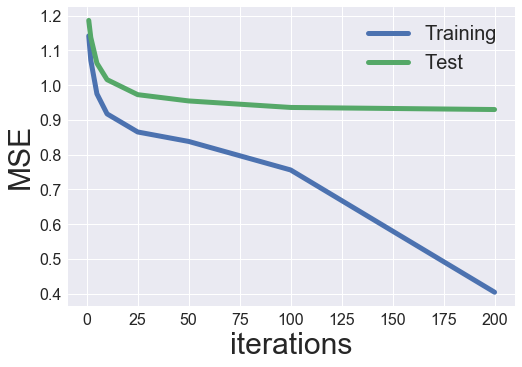

In [47]:
plot_learning_curve(iter_array, MF_SGD)

앞서 본 ALP보다 MSE가 훨씬 낮은 것을 확인할 수 있다. (*위에서는 가장 좋은 Test MSE가 8 근처에 나왔었다.*)

### 평가 및 개선 작업

ALS에서와 마찬가지로 Greedy-search를 통해서 hyperparameter를 결정하는 작업을 할 것이다. 최적화가 되지 않은 코드라 매우 느리니
적당히 parameter를 선정하자.

In [48]:
# learning_rate를 찾는 과정
iter_array = [1, 2, 5, 10] #, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print 'Rate: {}'.format(rate)
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print 'New optimal hyperparameters'
        print pd.Series(best_params)

Rate: 1e-05
New optimal hyperparameters
learning_rate                                               1e-05
model            <__main__.ExplicitMF instance at 0x7fd9f1aeea70>
n_iter                                                         10
test_mse                                                  1.25534
train_mse                                                  1.2507
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                              0.0001
model            <__main__.ExplicitMF instance at 0x7fd9f1b94908>
n_iter                                                         10
test_mse                                                  1.18655
train_mse                                                 1.14206
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                               0.001
model            <__main__.ExplicitMF instance at 0x7fd9f1b94200>
n_iter                                                     

In [49]:
# factor 수, regularization 값 찾는 과정
iter_array = [1, 2, 5] #, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20] #, 40, 80]
regularizations = [0.001, 0.01] #, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print 'New optimal hyperparameters'
            print pd.Series(best_params)

Factors: 5
Regularization: 0.001
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fd9f1a30d40>
n_factors                                                   5
n_iter                                                      5
reg                                                     0.001
test_mse                                              1.07299
train_mse                                            0.979169
dtype: object
Regularization: 0.01
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fd9f1b7f710>
n_factors                                                   5
n_iter                                                      5
reg                                                      0.01
test_mse                                              1.06921
train_mse                                            0.979317
dtype: object
Factors: 10
Regularization: 0.001
New optimal hyperparameters
model        <__main__.ExplicitMF instance at 0x7fd9f1b7

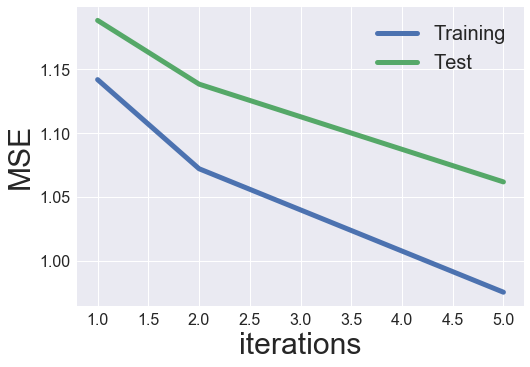

In [18]:
plot_learning_curve(iter_array, best_params['model'])

In [19]:
print 'Best regularization: {}'.format(best_params['reg'])
print 'Best latent factors: {}'.format(best_params['n_factors'])
print 'Best iterations: {}'.format(best_params['n_iter'])

Best regularization: 0.001
Best latent factors: 20
Best iterations: 5


best parameter를 factor가 20, regularization이 0.001, learning rate가 0.001일 때로 찾았다. 어느 정도 더 개선할 여지가 많이 있지만 일단 알고리즘을 익히기 위한 코드이므로 넘어가고 완성된 모델을 바탕으로 test를 해서 제대로 작동하는지 보도록 하자.

## Eye tests

우리는 영화 평점 데이터를 바탕으로 모델을 학습시켰다. user, item(영화) 각각이 모두 latent factor로 구성된 vector로 나타낼 수 있고 
쉽게 영화 간의 유사도를 구하거나 user가 어떤 영화를 좋아할 지에 대한 추천이 가능해진다. 여기에서는 ***cosine similarity***를 활용해서 
특정 영화를 입력했을 때 유사한 영화를 반환해주는 로직을 구현하려고 한다.

아래 코드를 돌리기 위해서는 [themoviedb.org](http://www.themoviedb.org)에 가입하고 API key를 받아야 한다. 많은 양을 돌리거나 하지 않으니 그냥 제 것을 쓰셔도 무방하다. 

ALS, SGD 각각에 대해서 돌려보고 나온 결과를 비교해보도록 하겠다.

In [50]:
# 최적의 모델이라고 구한 parameter를 적용한 ALS 모델, 데이터는 전체 데이터를 사용한다. 
best_als_model = ExplicitMF(ratings, n_factors=20, learning='als', \
                            item_fact_reg=0.01, user_fact_reg=0.01)
best_als_model.train(50)

In [51]:
# 최적의 모델이라고 구한 parameter를 적용한 SGD 모델, 데이터는 전체 데이터를 사용한다. 
best_sgd_model = ExplicitMF(ratings, n_factors=80, learning='sgd', \
                            item_fact_reg=0.01, user_fact_reg=0.01, \
                            user_bias_reg=0.01, item_bias_reg=0.01)
best_sgd_model.train(200, learning_rate=0.001)

cosine similarity를 계산하는 함수를 구현하자.

In [52]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

als_sim = cosine_similarity(best_als_model)
sgd_sim = cosine_similarity(best_sgd_model)

API에 query로 넘겨줄 값을 얻기 위해 우리가 분석한 영화의 url 정보를 모은다.

In [53]:
# Load in movie data
idx_to_movie = {}
with open('u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]

API를 통해 영화 poster 이미지를 얻는다. 

In [55]:
import requests
import json

api_key = '39aa821fe806edaa0e0ed315d97147ea'
headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
response = requests.get("http://api.themoviedb.org/3/configuration",\
                        params=payload,\
                        headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w500'

def get_poster(imdb_url, base_url, api_key):

    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    movie_title = imdb_url.split('?')[-1].split('(')[0].replace('%20', ' ')
    payload['query'] = movie_title
    response = requests.get('http://api.themoviedb.org/3/search/movie',\
                            params=payload,\
                            headers=headers)
    try:
        movie_id = json.loads(response.text)['results'][0]['id']
        payload.pop('query', None)
        movie_url = 'http://api.themoviedb.org/3/movie/{:}'\
                    .format(movie_id)
        response = requests.get(movie_url, params=payload, headers=headers)
        file_path = json.loads(response.text)['poster_path']
    except:
        # 가끔 잘 안 돌아갈 때가 있다고 한다. 그래서 예외 처리를 해주고 ''값을 return 한다.
        return ''

    return base_url + file_path

Jupyter notebook cell에 poster를 나타낸다. IPython.display method를 사용했다. [stackoverflow](http://stackoverflow.com/a/27795087) 에서 도움을 얻었다고 한다.

In [56]:
from IPython.display import HTML
from IPython.display import display

def display_top_k_movies(similarity, mapper, movie_idx, base_url, api_key, k=5):
    movie_indices = np.argsort(similarity[movie_idx,:])[::-1]
    images = ''
    k_ctr = 0
    # Start i at 1 to not grab the input movie
    i = 1
    while k_ctr < 5:
        movie = mapper[movie_indices[i]]
        poster = get_poster(movie, base_url, api_key)
        if poster != '':
            images += "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />"\
                      % poster
            k_ctr += 1
        i += 1
    display(HTML(images))

def compare_recs(als_similarity, sgd_similarity, mapper,\
                 movie_idx, base_url, api_key, k=5):
    # Display input
    display(HTML('<font size=5>'+'Input'+'</font>'))
    input_poster = get_poster(mapper[movie_idx], base_url, api_key)
    input_image = "<img style='width: 120px; margin: 0px; \
                      float: left; border: 1px solid black;' src='%s' />" \
                  % input_poster
    display(HTML(input_image))
    # Display ALS Recs
    display(HTML('<font size=5>'+'ALS Recs'+'</font>'))
    display_top_k_movies(als_similarity, idx_to_movie,\
                         movie_idx, base_url, api_key)
    # Display SGD Recs
    display(HTML('<font size=5>'+'SGD Recs'+'</font>'))
    display_top_k_movies(sgd_similarity, idx_to_movie,\
                         movie_idx, base_url, api_key)

이제 ALS, SGD 학습 모델에 대해 돌려보자.

In [63]:
idx = 0 # 영화: toy story
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [58]:
idx = 20 # 영화: Muppet Treasure Island
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [59]:
idx = 40 # 영화: Billy Madison
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

In [60]:
idx = 500 # 영화: Dumbo
compare_recs(als_sim, sgd_sim, idx_to_movie, idx, base_url, api_key)

결과를 봤을 때 ALS, SGD 모두 어느 정도까지는 영화에 대한 학습이 이루어진 것을 볼 수 있다. (*특히 Dumbo!!*) 그리고 MSE의 차이가 ALS과 SGD가 많이 남에도 불구하고 ALS의 결과가 더 좋아보이는 것들도 있다. ALS와 SGD의 성능에 대한 비교에 대해서 블로그 저자도 언급하고 있는데 
아래 내용이 명확하게 이해가 되지 않아 원문 그대로 남겨두도록 하겠다. 더 궁금하신 분들은 아래 링크의 논문이나 사이트를 보면 될 듯하다.


### ALS vs SGD?

So how do we think we did? I find it very interesting that the best test MSE for our ALS model was 8.07 compared to 0.88 for SGD. That's a giant difference, and yet I think the ALS recommendations might actually beat out the SGD ones; particularly, the GoldenEye and Dumbo recommendations.

I have found similar behavior in some of my own work, as well. I have a vague hunch that SGD tends to overfit more than ALS and is more susceptible to popularity bias. Unfortunately, I have zero math to back this up, so it'll remain purely anecdotal for now. An alternative explanation could be that the SGD movie-to-movie recommendations are actually better than the ALS ones even if they seem like less similar movies. In a recent Netflix [paper](http://dl.acm.org/citation.cfm?id=2843948), they show a similar comparison of two different models' movie-to-movie recommendations. It turns out that the model with movies that look less similar by eye (but are generally more popular movies) performs better on A/B tests. And really, A/B tests are a much better way of truly benchmarking recommendation systems compared to this offline data modeling.

And on a final note, maybe we would want to just combine both models into an ensemble which seems to be what [everbody does](https://medium.com/@xamat/10-more-lessons-learned-from-building-real-life-ml-systems-part-i-b309cafc7b5e) nowadays.
